### Import Libraries

In [133]:
#pip install xgboost

In [134]:
# pip install -U scikit-learn


In [135]:
#pip install --upgrade pip

In [136]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
from xgboost import XGBRegressor

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

**Install MAPIE via `pip`**:

`!pip install mapie`

In [137]:
#!pip install mapie==0.9.1

### Load Dataset

In [138]:
# Import Data
df = pd.read_csv('Traffic_Volume.csv')
#df = df.head(200)
df['date_time'] = pd.to_datetime(df['date_time'])
df['month'] = df['date_time'].dt.month
df['weekday'] = df['date_time'].dt.dayofweek
df['hour'] = df['date_time'].dt.hour
df = df.drop(columns=['date_time'])
df.head(20)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,weekday,hour
0,NaN,288.28,0.0,0.0,40,Clouds,5545,10,1,9
1,NaN,289.36,0.0,0.0,75,Clouds,4516,10,1,10
2,NaN,289.58,0.0,0.0,90,Clouds,4767,10,1,11
3,NaN,290.13,0.0,0.0,90,Clouds,5026,10,1,12
4,NaN,291.14,0.0,0.0,75,Clouds,4918,10,1,13
5,NaN,291.72,0.0,0.0,1,Clear,5181,10,1,14
6,NaN,293.17,0.0,0.0,1,Clear,5584,10,1,15
7,NaN,293.86,0.0,0.0,1,Clear,6015,10,1,16
8,NaN,294.14,0.0,0.0,20,Clouds,5791,10,1,17
9,NaN,293.10,0.0,0.0,20,Clouds,4770,10,1,18


In [139]:
# Select input and output features
X = df.drop(columns = ['traffic_volume'])
y = df['traffic_volume']

In [140]:
# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,month,weekday,hour,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,288.28,0.0,0.0,40,10,1,9,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,10,1,10,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,10,1,11,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,10,1,12,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,10,1,13,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [141]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

### Implement Random Forest Regressor

In [142]:
# Define your model
xgb_reg = XGBRegressor(
    n_estimators=2,
    learning_rate=0.1,
    max_depth=4,
    tree_method='hist',   # much faster on CPU
    n_jobs=-1,            # use all CPU cores
    random_state=42
)


In [143]:
# Fit the model
start = time.time()            # Start Time
xgb_reg.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 0.03558921813964844s


#### Evaluate Prediction Performance on Test Set

In [144]:
# from sklearn.metrics import mean_squared_error
# import numpy as np

# mse = mean_squared_error(test_y, y_pred)
# rmse = np.sqrt(mse)
# print("RMSE:", rmse)

In [145]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on train set
y_pred_train = xgb_reg.predict(train_X)

# Evaluate R²
r2 = r2_score(train_y, y_pred_train)
print('R-squared on Train Set: %.2f' % r2)

# Evaluate RMSE (manual sqrt for full compatibility)
rmse_train = np.sqrt(mean_squared_error(train_y, y_pred_train))
print('RMSE on Train Set: %.2f' % rmse_train)


R-squared on Train Set: 0.30
RMSE on Train Set: 1656.55


#### Histogram of Residuals/Errors 

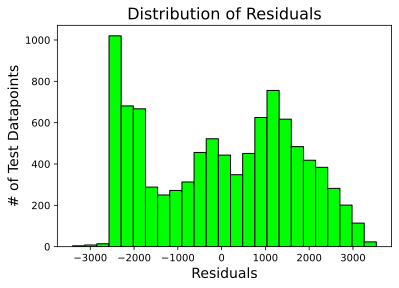

In [146]:
# Calculate the residuals by subtracting the predicted values from the actual test values
y_pred_test = xgb_reg.predict(test_X)
all_residuals = test_y - y_pred_test

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("residuals_dist.svg")
plt.show()

#### Scatter Plot of Predicted Vs. Actual Values

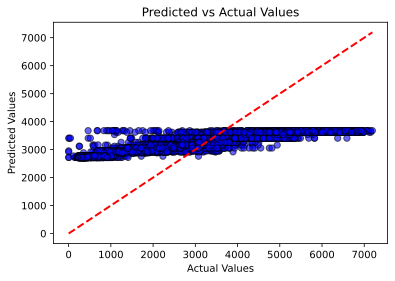

In [147]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred_test, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("pred_vs_act.svg");
plt.show()


#### Feature Importance Plot

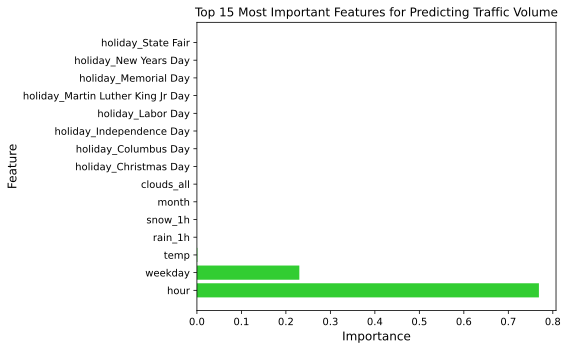

In [148]:
# Storing importance values from the trained model
importance = xgb_reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# # Bar plot
# plt.figure(figsize=(8, 4))
# plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

# plt.xlabel("Importance", fontsize = 12)
# plt.ylabel("Input Feature", fontsize = 12)
# plt.title('Which features are the most important for predicting traffic volume?', fontsize = 12) 
# plt.yticks(fontsize = 10) # fontsize of yticks
# plt.xticks(fontsize = 10) # fontsize of xticks

# plt.tight_layout();
# plt.savefig("feature_imp.svg");
# plt.show()

top_n = 15
feature_imp_top = feature_imp.head(top_n)

# Plot only top features
plt.figure(figsize=(8, 5))
plt.barh(feature_imp_top['Feature'], feature_imp_top['Importance'], color='limegreen')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title(f"Top {top_n} Most Important Features for Predicting Traffic Volume", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.savefig("feature_imp.svg")
plt.show()


### Prediction Intervals for Regression
<img src="Prediction_Interval.png" width="500" style="float: center"/>

#### **What is a Prediction Interval?**
- It is a **range of values** within which a new observation is expected to fall with a **certain probability**, given the existing data and model.

- **Probability**: The width of the prediction interval depends on the **desired confidence level**, (e.g., 95%), with higher confidence levels leading to wider intervals.

#### **Confidence Level of Prediction Interval**

- The confidence level of a prediction interval indicates the probability that the interval will contain the true value of the parameter being estimated.

- Mathematically, the confidence level of a prediction interval is denoted by $ (1 - \alpha) \times 100\% $, where $ \alpha $ is the significance level.

#### **Why Prediction Intervals are Useful?**

- **Uncertainty Quantification**: They provide a measure of the uncertainty in individual predictions, which is crucial for risk assessment and decision-making.

- **Communication**: They are an effective tool for communicating the uncertainty in predictions to stakeholders, making the model's predictions more interpretable.

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

In [149]:
# import os
# os.cpu_count()


In [150]:
mapie = MapieRegressor(
    estimator=xgb_reg,
    method="plus",   # still gives valid intervals
    cv="split",      # prevents refitting for each fold
    n_jobs=-1,
    random_state=42
)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

#y_test_pred -> Point Pred
#y_test_pis -> interval pred

Training time: 3.1575212478637695s


In [151]:
# Predicted values
y_test_pred

array([3676.0657, 3161.2346, 2762.5989, ..., 3054.4666, 3054.4666,
       2719.5054], shape=(9641,), dtype=float32)

In [152]:
# Prediction Intervals
y_test_pis

array([[[1269.56030273],
        [6082.57104492]],

       [[ 754.72924805],
        [5567.73999023]],

       [[ 356.09350586],
        [5169.10424805]],

       ...,

       [[ 647.96118164],
        [5460.97192383]],

       [[ 647.96118164],
        [5460.97192383]],

       [[ 313.        ],
        [5126.01074219]]], shape=(9641, 2, 1))

In [153]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,3054.469971,647.96,5460.97
34004,5251,3620.080078,1213.58,6026.59
46086,2224,3054.469971,647.96,5460.97
42579,2928,3054.469971,647.96,5460.97
23709,910,2719.510010,313.00,5126.01


### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [154]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 89.30%


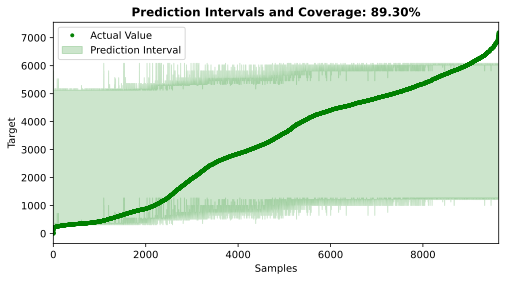

In [155]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);
plt.savefig("coverage_plot.svg");
plt.show()

### Save Model

In [156]:
# Creating the file where we want to write the model
xgb_traffic = open('xgb_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, xgb_traffic) 

# Close the file
xgb_traffic.close()

In [157]:
# # Save model AND feature columns
# with open('xgb_feature_cols.pickle', 'wb') as f:
#     pickle.dump(list(X_encoded.columns), f)

# mapie.fit(X_encoded, y)
# with open('xgb_traffic.pickle', 'wb') as f:
#     pickle.dump(mapie, f)